# D. State stabilization in a noisy environment with Jaynes-Cummings controls

Here the result is as follows: The algorithm optimizes the params, such that the POVM always outputs 1, implying that the measurement leaves the target state invariant. this is what we are indeed seeing when printing the measurement outcome and its probability, when batching however, the optimizer struggles to converge.

Also, lookup here is much better than nn for the same hyperparameters.

This is actually a perfect example, of feedback grape modifying the params so that a certain measurement sequence will always be output because this measurement sequence is the one that is going to lead to the best fidelity

In [16]:
# ruff: noqa
import os

#os.sys.path.append("../../../..")
os.sys.path.append("./../../feedback-grape")

In [17]:
from feedback_grape.fgrape import optimize_pulse
from feedback_grape.utils.operators import (
    sigmap,
    sigmam,
    create,
    destroy,
    identity,
    cosm,
    sinm,
)
from feedback_grape.utils.states import basis, fock
from feedback_grape.utils.tensor import tensor
import jax.numpy as jnp
from jax.scipy.linalg import expm

In [18]:
N_cav = 30

## Here, dividing alpha into real and imaginary parts complicates the optimization and converges at 0.89 while if we do not use the imaginary part it converges at 0.999

In [19]:
def qubit_unitary(alpha_re):
    alpha = alpha_re[0]
    return tensor(
        identity(N_cav),
        expm(-1j * (alpha * sigmap() + alpha.conjugate() * sigmam()) / 2),
    )

In [20]:
def qubit_cavity_unitary(beta_re):
    beta = beta_re[0]
    return expm(
        -1j
        * (
            beta * (tensor(destroy(N_cav), sigmap()))
            + beta.conjugate() * (tensor(create(N_cav), sigmam()))
        )
        / 2
    )

### povm_measure_operator (callable): <br>
    - It should take a measurement outcome and list of params as input
    - The measurement outcome options are either 1 or -1

In [21]:
from feedback_grape.utils.operators import create, destroy


def povm_measure_operator(measurement_outcome, params):
    """
    POVM for the measurement of the cavity state.
    returns Mm ( NOT the POVM element Em = Mm_dag @ Mm ), given measurement_outcome m, gamma and delta
    """
    gamma, delta = params
    number_operator = tensor(create(N_cav) @ destroy(N_cav), identity(2))
    angle = (gamma * number_operator) + delta / 2 * identity(2*N_cav)
    meas_op = jnp.where(
        measurement_outcome == 1,
        cosm(angle),
        sinm(angle),
    )
    return meas_op

In [22]:
from feedback_grape.utils.states import coherent

alpha = 3
psi_target = tensor(
    coherent(N_cav, alpha)
    + coherent(N_cav, -alpha)
    + coherent(N_cav, 1j * alpha)
    + coherent(N_cav, -1j * alpha),
    basis(2),
)  # 4-legged state

# Normalize psi_target before constructing rho_target
psi_target = psi_target / jnp.linalg.norm(psi_target)
rho_target = psi_target @ psi_target.conj().T

In [23]:
rho_target.shape

(60, 60)

### It is important to test what the POVM probability is, to check if your state is normalized. if the probability is bounded between 0 and 1 then normalized

In [24]:
# Answer: should one normalize within the optimization just in case?
# --> no so that user is not misled into thinking that his unnormalized state
# is working properly
from feedback_grape.utils.povm import (
    _probability_of_a_measurement_outcome_given_a_certain_state,
)

_probability_of_a_measurement_outcome_given_a_certain_state(
    rho_target,
    1,
    povm_measure_operator,
    [0.058, jnp.pi / 2],
    evo_type="density",
)

Array(0.09369074, dtype=float64)

In [25]:
from feedback_grape.utils.fidelity import fidelity

print(fidelity(U_final=rho_target, C_target=rho_target, evo_type="density"))

1.0000000233601563


### Without dissipation

In [26]:
# Here the loss directly corressponds to the -fidelity (when converging) because log(1) is 0 and
# the algorithm is choosing params that makes the POVM generate prob = 1
from feedback_grape.fgrape import Gate, Decay

measure = Gate(
    gate=povm_measure_operator,
    initial_params=[0.058, jnp.pi / 2],  # gamma and
    measurement_flag=True,
)

qub_unitary = Gate(
    gate=qubit_unitary,
    initial_params=[jnp.pi / 3],  # alpha
    measurement_flag=False,
    # "param_constraints": [[0, 0.5], [-1, 1]],
)

qub_cav = Gate(
    gate=qubit_cavity_unitary,
    initial_params=[jnp.pi / 3],  # beta
    measurement_flag=False,
    # "param_constraints": [[0, 0.5], [-1, 1]],
)


system_params = [measure, qub_unitary, qub_cav]
result = optimize_pulse(
    U_0=rho_target,
    C_target=rho_target,
    system_params=system_params,
    num_time_steps=1,
    mode="lookup",
    goal="fidelity",
    max_iter=1000,
    convergence_threshold=1e-16,
    learning_rate=0.005,
    evo_type="density",
    batch_size=1,
)

In [27]:
# 0.999995162213917
print(result.final_fidelity)

0.7947506829642431


In [28]:
result.optimized_trainable_parameters["initial_params"]

[Array([1.00507049e-05, 3.14139441e+00], dtype=float64),
 Array([1.04719755], dtype=float64),
 Array([1.04719755], dtype=float64)]

In [29]:
result.returned_params

[[Array([[1.00507049e-05, 3.14139441e+00],
         [1.00507049e-05, 3.14139441e+00],
         [1.00507049e-05, 3.14139441e+00],
         [1.00507049e-05, 3.14139441e+00],
         [1.00507049e-05, 3.14139441e+00],
         [1.00507049e-05, 3.14139441e+00],
         [1.00507049e-05, 3.14139441e+00],
         [1.00507049e-05, 3.14139441e+00],
         [1.00507049e-05, 3.14139441e+00],
         [1.00507049e-05, 3.14139441e+00]], dtype=float64),
  Array([[-8.97406709e-06],
         [-8.97406709e-06],
         [-8.97406709e-06],
         [-8.97406709e-06],
         [-8.97406709e-06],
         [-8.97406709e-06],
         [-8.97406709e-06],
         [-8.97406709e-06],
         [-8.97406709e-06],
         [-8.97406709e-06]], dtype=float64),
  Array([[1.96205678],
         [1.96205678],
         [1.96205678],
         [1.96205678],
         [1.96205678],
         [1.96205678],
         [1.96205678],
         [1.96205678],
         [1.96205678],
         [1.96205678]], dtype=float64)]]

In [30]:
from feedback_grape.utils.fidelity import fidelity

print(
    "initial fidelity:",
    fidelity(C_target=rho_target, U_final=rho_target, evo_type="density"),
)
for i, state in enumerate(result.final_state):
    print(
        f"fidelity of state {i}:",
        fidelity(C_target=rho_target, U_final=state, evo_type="density"),
    )

initial fidelity: 1.0000000233601563
fidelity of state 0: 0.7947506829642431
fidelity of state 1: 0.7947506829642431
fidelity of state 2: 0.7947506829642431
fidelity of state 3: 0.7947506829642431
fidelity of state 4: 0.7947506829642431
fidelity of state 5: 0.7947506829642431
fidelity of state 6: 0.7947506829642431
fidelity of state 7: 0.7947506829642431
fidelity of state 8: 0.7947506829642431
fidelity of state 9: 0.7947506829642431


### With Dissipation

In [ ]:
# Note if tsave = jnp.linspace(0, 1, 1) = [0.0] then the decay is not applied ?
# because the first time step has the original non decayed state
# Question: Here I should not use any sort of Hamiltonian or tspan or something?
decay = Decay(
    c_ops=[tensor(identity(N_cav), jnp.sqrt(0.10) * sigmam())],
)
system_params = [decay, measure, qub_unitary, qub_cav]
result = optimize_pulse(
    U_0=rho_target,
    C_target=rho_target,
    system_params=system_params,
    num_time_steps=1,
    mode="lookup",
    goal="fidelity",
    max_iter=1000,
    convergence_threshold=1e-6,
    learning_rate=0.005,
    evo_type="density",
    batch_size=1,
)

In [32]:
print(result.final_fidelity)

0.7179442719305446


In [33]:
from feedback_grape.utils.fidelity import fidelity

print(
    "initial fidelity:",
    fidelity(C_target=rho_target, U_final=rho_target, evo_type="density"),
)
for i, state in enumerate(result.final_state):
    print(
        f"fidelity of state {i}:",
        fidelity(C_target=rho_target, U_final=state, evo_type="density"),
    )

initial fidelity: 1.0000000233601563
fidelity of state 0: 0.7179442719305444
fidelity of state 1: 0.7179442719305444
fidelity of state 2: 0.7179442719305444
fidelity of state 3: 0.7179442719305444
fidelity of state 4: 0.7179442719305444
fidelity of state 5: 0.7179442719305444
fidelity of state 6: 0.7179442719305444
fidelity of state 7: 0.7179442719305444
fidelity of state 8: 0.7179442719305444
fidelity of state 9: 0.7179442719305444


In [34]:
result.returned_params

[[Array([[0.03682863, 2.41429643],
         [0.03682863, 2.41429643],
         [0.03682863, 2.41429643],
         [0.03682863, 2.41429643],
         [0.03682863, 2.41429643],
         [0.03682863, 2.41429643],
         [0.03682863, 2.41429643],
         [0.03682863, 2.41429643],
         [0.03682863, 2.41429643],
         [0.03682863, 2.41429643]], dtype=float64),
  Array([[-5.88287224e-06],
         [-5.88287224e-06],
         [-5.88287224e-06],
         [-5.88287224e-06],
         [-5.88287224e-06],
         [-5.88287224e-06],
         [-5.88287224e-06],
         [-5.88287224e-06],
         [-5.88287224e-06],
         [-5.88287224e-06]], dtype=float64),
  Array([[1.91975974],
         [1.91975974],
         [1.91975974],
         [1.91975974],
         [1.91975974],
         [1.91975974],
         [1.91975974],
         [1.91975974],
         [1.91975974],
         [1.91975974]], dtype=float64)]]

In [35]:
result.optimized_trainable_parameters["initial_params"]

[Array([0.03682863, 2.41429643], dtype=float64),
 Array([1.04719755], dtype=float64),
 Array([1.04719755], dtype=float64)]

### Evaluate performance of optimized architecture on longer time span

In [36]:
from feedback_grape.fgrape import evaluate_on_longer_time

result_long = evaluate_on_longer_time(
    U_0 = rho_target,
    C_target = rho_target,
    system_params = system_params,
    optimized_trainable_parameters = result.optimized_trainable_parameters,
    num_time_steps = 100,
    evo_type = "density",
    goal = "fidelity",
    mode = "lookup",
    rnn = None,
    eval_batch_size = 10,
    rnn_hidden_size = 30,
)

fidelities_long = result_long.fidelity_each_timestep

Text(0, 0.5, 'fidelity')

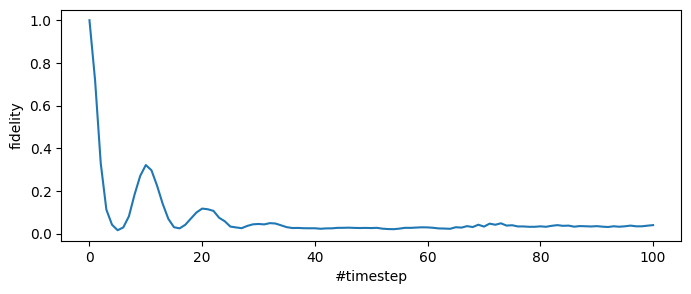

In [37]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8,3))
ax.plot(fidelities_long)
ax.set_xlabel("#timestep")
ax.set_ylabel("fidelity")

### Try again with uniform reward weights

In [41]:
# Note if tsave = jnp.linspace(0, 1, 1) = [0.0] then the decay is not applied ?
# because the first time step has the original non decayed state
# Question: Here I should not use any sort of Hamiltonian or tspan or something?
num_time_steps = 2
num_of_iterations = 1000
learning_rate = 0.02
result_2 = optimize_pulse(
    U_0=rho_target,
    C_target=rho_target,
    system_params=system_params,
    num_time_steps=num_time_steps,
    reward_weights = [1]*num_time_steps,
    mode="lookup",
    goal="fidelity",
    max_iter=num_of_iterations,
    convergence_threshold=1e-6,
    learning_rate=learning_rate,
    evo_type="density",
    batch_size=10,
)

In [42]:
from feedback_grape.fgrape import evaluate_on_longer_time

result_long_2 = evaluate_on_longer_time(
    U_0 = rho_target,
    C_target = rho_target,
    system_params = system_params,
    optimized_trainable_parameters = result_2.optimized_trainable_parameters,
    num_time_steps = 100,
    evo_type = "density",
    goal = "fidelity",
    mode = "lookup",
    eval_batch_size=10,
    rnn=None,
    rnn_hidden_size=30,
)

fidelities_long_2 = result_long_2.fidelity_each_timestep

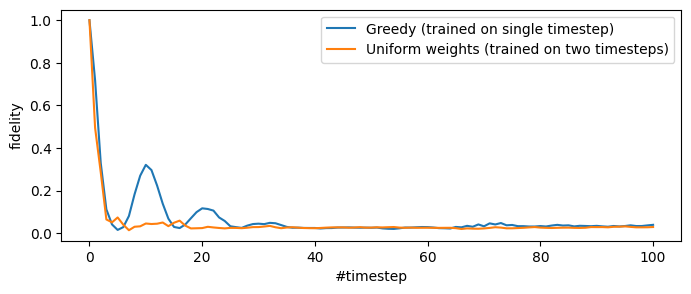

In [43]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8,3))
ax.plot(fidelities_long, label="Greedy (trained on single timestep)")
ax.plot(fidelities_long_2, label="Uniform weights (trained on two timesteps)")
ax.set_xlabel("#timestep")
ax.set_ylabel("fidelity")
ax.legend()
fig.savefig("example_D_fixed_evaluation.png")